### Analysis of White masks in the steel sheets

In [12]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap
import warnings

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc

### Load data

In [4]:
n_classes = 2
class_labels = {0: 'No Defects', 1: 'Defects'}
params = c_utils.get_default_params()
device = torch.device('cuda')
#warnings.filterwarnings("ignore")

In [5]:
MODEL_PATH = '../model/OfficialBinaryModels/AugmentedSqueezeReduced10.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/binaryData'
METADATA_PATH = '../data/binaryData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test_binary.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test_binary.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test_binary.pth'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


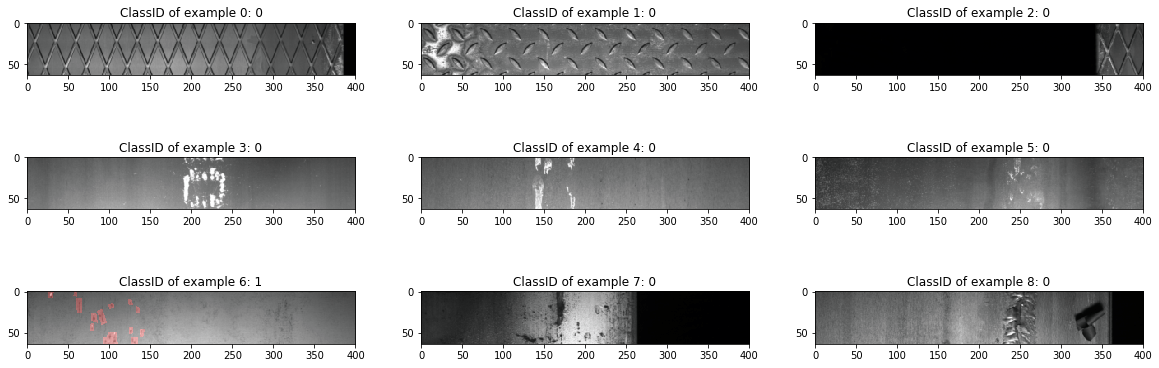

In [10]:
X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)

fig, ax = plt.subplots(3, 3, figsize=(20, 7))
start = 0
for i in range(start, start+9):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

### Model

In [13]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 2))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

y_pred, y_true, y_score = [], [], torch.Tensor([])
batch_size = 5

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)))

100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [00:07<00:00, 69.60it/s]

Accuracy: 0.9390	F1 Score: 0.9423


### Analysis TSNE

#### 1. Input

In [ ]:
tsne_results = []
tsne = TSNE(perplexity=2, n_jobs=-1)
tsne_results.append(tsne.fit_transform(X_val[:-3].numpy().reshape(X_val[:-3].shape[0], -1)))

In [ ]:
plt.scatter(tsne_results[0][:, 0][y_true == 0], tsne_results[0][:, 1][y_true == 0], alpha=0.45, label='No Defects')
plt.scatter(tsne_results[0][:, 0][y_true == 1], tsne_results[0][:, 1][y_true == 1], alpha=0.30, label='Defects')
plt.legend()
plt.title('T-SNE on the input')
plt.grid()
plt.show()

#### 2. Squeeze Fire layer

In [ ]:
indexes = [3, 4, 6, 7, 9]
for i in indexes:
    tsne_X = torch.Tensor([])
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.features[i].squeeze(net.features[:i](X)).detach().cpu()
        tsne_X = torch.cat([tsne_X, out])
    tsne_X = tsne_X.numpy()
    tsne = TSNE(perplexity=2, n_jobs=-1)
    X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
    tsne_results.append(X_val_tsne)

#### 3. Last Layer

In [ ]:
tsne_X = torch.Tensor([])
net.eval()
for n in range(X_val.shape[0]//batch_size):
    X = X_val[n*batch_size:(n+1)*batch_size].to(device)
    out = net.classifier[:1](net.features(X)).detach().cpu()
    tsne_X = torch.cat([tsne_X, out])
tsne_X = tsne_X.numpy()
tsne = TSNE(perplexity=2, n_jobs=-1)
X_val_tsne = tsne.fit_transform(tsne_X.reshape(tsne_X.shape[0], -1))
tsne_results.append(X_val_tsne)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 12))
for i in range(6):
    ax[i//3, i%3].scatter(tsne_results[i+1][:, 0][y_true == 0], 
                       tsne_results[i+1][:, 1][y_true == 0], 
                       alpha=0.45, label='No Defects')
    ax[i//3, i%3].scatter(tsne_results[i+1][:, 0][y_true == 1], 
                  tsne_results[i+1][:, 1][y_true == 1], 
                  alpha=0.30, label='Defects')
    ax[i//3, i%3].legend()
    ax[i//3, i%3].set_title('T-SNE on the {} layer'.format(i))
    ax[i//3, i%3].grid()
plt.show()

### Maninfold capacity

In [ ]:
print('Squeeze input: {}'.format(3*64*400))
print('Squeeze 1st Fire: {}'.format(16*15*99))
print('Squeeze 2nd Fire: {}'.format(16*15*99))
print('Squeeze 3rd Fire: {}'.format(32*7*49))
print('Squeeze 4th Fire: {}'.format(32*7*49))
print('Squeeze 5th Fire: {}'.format(48*3*24))